# GENRE CLASSIFICATION USING BOOK SUMMARIES

### Importing necessary libraries

In [11]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

from bs4 import BeautifulSoup
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import accuracy_score,f1_score

### Loading the data

In [12]:
data = []

with open(r"D:\Projects\Book-Genre-Prediction\books\books.txt",encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in tqdm(reader, desc="Processing rows"):
        data.append(row)

Processing rows: 16559it [00:00, 28542.34it/s]


In [13]:
# Converting the text data to dataframe

book_id = []
book_name = []
summary = []
genre = []

for i in tqdm(data):
    book_id.append(i[0])
    book_name.append(i[2])
    genre.append(i[5])
    summary.append(i[6])

books = pd.DataFrame({'book_id': book_id, 'book_name': book_name,
                       'genre': genre, 'summary': summary})
books.head()

100%|██████████| 16559/16559 [00:00<00:00, 1936039.47it/s]


,book_id,book_name,genre,summary
0,620,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"": ""Satire"", ""/m/0dwly"": ""Children's literature"", ""/m/014dfn"": ""Speculative fiction"", ""/m/02xlf"": ""Fiction""}","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,843,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""Novella"", ""/m/014dfn"": ""Speculative fiction"", ""/m/0c082"": ""Utopian and dystopian fiction"", ""/m/06nbt"": ""Satire"", ""/m/02xlf"": ""Fiction""}","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,986,The Plague,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fiction"", ""/m/0pym5"": ""Absurdist fiction"", ""/m/05hgj"": ""Novel""}","The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."
3,1756,An Enquiry Concerning Human Understanding,,"The argument of the Enquiry proceeds by a series of incremental steps, separated into chapters which logically succeed one another. After expounding his epistemology, Hume explains how to apply his principles to specific topics. In the first section of the Enquiry, Hume provides a rough introdu..."
4,2080,A Fire Upon the Deep,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""Speculative fiction"", ""/m/01hmnh"": ""Fantasy"", ""/m/02xlf"": ""Fiction""}","The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti..."


In [14]:
books.shape

(16559, 4)

In [15]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   book_id    16559 non-null  object
 1   book_name  16559 non-null  object
 2   genre      16559 non-null  object
 3   summary    16559 non-null  object
dtypes: object(4)
memory usage: 517.6+ KB


### Preprocessing

In [16]:
# dropping rows with null values in genre

books.drop(books[books['genre']==''].index, inplace=True)
books[books['genre']=='']

,book_id,book_name,genre,summary


In [17]:
json.loads(books['genre'][0]).values()

dict_values(['Roman à clef', 'Satire', "Children's literature", 'Speculative fiction', 'Fiction'])

In [18]:
#finding all genres in the dataset

genres = []
for i in books['genre']:
    genres.append(list(json.loads(i).values()))
books['genre_new'] = genres

all_genres = sum(genres,[])
len(set(all_genres))

227

In [19]:
all_genres=pd.Series(all_genres)

In [20]:
all_genres.value_counts()

Fiction                             4747
Speculative fiction                 4314
Science Fiction                     2870
Novel                               2463
Fantasy                             2413
                                    ... 
Popular culture                        1
New York Times Best Seller list        1
Epic Science Fiction and Fantasy       1
Alien invasion                         1
Pastiche                               1
Name: count, Length: 227, dtype: int64

<Axes: >

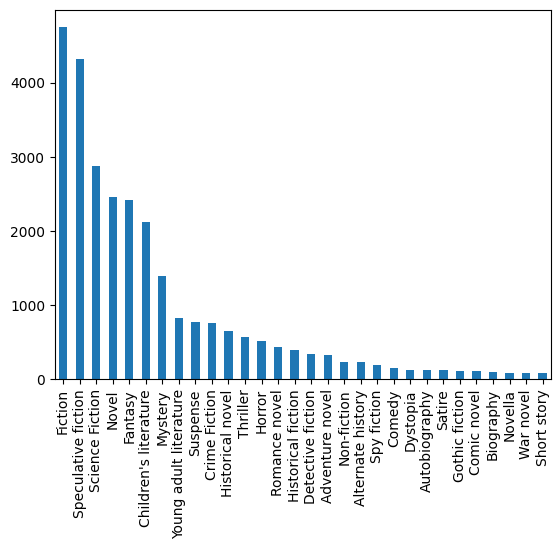

In [21]:
all_genres.value_counts()[:30].plot(kind='bar')

#### Cleaning the text

In [29]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#function to load the lemmatize text

load_model=spacy.load('en_core_web_sm',disable=['parser','ner'])
def lemmatize(text):
    doc=load_model(text)
    tex=" ".join([token.lemma_ for token in doc])
    return tex

# function to clean text
def clean_summary(text):
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub("\'", "", text)
    text = re.sub("[^a-zA-Z]"," ",text)
    text = ' '.join(text.split())
    text = text.lower()
    text =  " ".join([t for t in text.split() if t not in stop_words])
    text=lemmatize(text)
    return text

In [30]:
books['clean_summary'] = books['summary'].apply(lambda x: clean_summary(x))
books.head(2)

FeatureNotFound: Couldn't find a tree builder with the features you requested: lxml. Do you need to install a parser library?

#### Word Cloud

In [ ]:
plt.figure(figsize=(10,7))
wc=WordCloud(min_font_size=3,max_words=3000,width=1000,height=800,
             stopwords=stop_words).generate(str(" ".join(books.clean_summary)))
plt.imshow(wc,interpolation='bilinear')

### Modeling

In [12]:
# labelling genre - multiclass

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(books['genre_new'])

y = multilabel_binarizer.transform(books['genre_new'])

In [ ]:
y[3]

In [14]:
# splitting the dataset

Xtrain,Xtest,y_train,y_test = train_test_split(books['clean_summary'],y,test_size=0.2)

In [15]:
# converting text to vectors

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
X_train = tfidf_vectorizer.fit_transform(Xtrain)
X_test = tfidf_vectorizer.transform(Xtest)

#### Fitting Models

In [16]:
lr = LogisticRegression()
rfc = RandomForestClassifier()

##### Running One vs Rest Classifier

In [ ]:
# using logistic regression
OvsRC = OneVsRestClassifier(lr)
OvsRC.fit(X_train, y_train)
y_pred_lr = OvsRC.predict(X_test)
accuracy_scorelr=accuracy_score(y_test, y_pred_lr)


In [ ]:
print("One vs Rest Classifier(LR)",accuracy_scorelr)

In [ ]:
rfc.fit(X_train,y_train)
y_pred_rf=rfc.predict(X_test)
print("Random Forest:",accuracy_score(y_test, y_pred_rf))

In [29]:
pred_prob = OvsRC.predict_proba(X_test)

In [36]:
t = 0.6
predp = (pred_prob >= t).astype(int)
#f1_score(y_test, predp, average="micro"), accuracy_score(y_test, predp)

### Prediction of the genre

In [54]:
def predict(text):
    text = clean_summary(text)
    text_vec = tfidf_vectorizer.transform([text])
    text_pred = OvsRC.predict(text_vec) 
    return multilabel_binarizer.inverse_transform(text_pred)

In [ ]:
for i in range(10):
    k = Xtest.sample(1).index[0]
    print("Book: ", books['book_name'][k],"\nPredicted genre: ", predict(Xtest[k]))
    print("Actual genre: ",books['genre_new'][k], "\n")